In [3]:
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import datetime
import re
import praw
import jsonlines


[nltk_data] Downloading package punkt to /home/ruru22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ruru22/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ruru22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
client_id = 'sIXZTihLNiKiHw'
client_secret = 'EjfAsmz5z8mDbZohe4UPYTPIZsYmOQ'
user_agent = 'Test1'

date_limits = ['2019-03-01 00:00:00', 
               '2019-06-01 00:00:00', 
               '2019-09-01 00:00:00', 
               '2020-01-01 00:00:00', 
               '2020-03-01 00:00:00', 
               '2020-06-01 00:00:00', 
               '2020-09-01 00:00:00', 
               '2021-01-01 00:00:00', 
               '2021-03-01 00:00:00', 
               '2021-06-01 00:00:00'
            ]

COUNT = len(date_limits)

In [5]:
def dfFromCSV(filename):
    posts = pd.read_csv(filename)
    return posts

def dfToCSV(posts, filename):
    posts.to_csv(filename, index=False)

def postsFromNDJSON(filename):
    posts = []
    with jsonlines.open(filename) as reader:
        for line in reader:
            line = line["Item"]
            posts.append([line["created"]["S"], line["title"]["S"], line["id"]["S"]])
    posts = pd.DataFrame(posts,columns=['created', 'title', 'id'])

    return posts

def sortByTime(data):
    data = data.sort_values(by='created')
    return data

posts = postsFromNDJSON("worldnews.jsonl")
posts = sortByTime(posts)
posts.drop(posts.loc[posts['title'] == 'None'].index, inplace=True)
dfToCSV(posts=posts, filename="worldnews.csv")
print(posts)


                    created  \
360671  2018-12-31 02:25:14   
270512  2018-12-31 02:27:21   
112640  2018-12-31 02:27:56   
294115  2018-12-31 02:29:05   
214742  2018-12-31 02:29:18   
...                     ...   
498320  2021-04-09 21:26:18   
427024  2021-04-09 21:26:19   
816977  2021-04-09 21:26:20   
144817  2021-04-09 21:26:21   
516521  2021-04-09 21:26:28   

                                                    title      id  
360671  پسکوف: هیچ اقدامی علیه مظنونان معرفی گردیده در...  ab2og2  
270512  One of the companies contracted by the governm...  ab2p2z  
112640  Donald Trump: Outgoing chief of staff John Kel...  ab2p8u  
294115  Todd Bowles Fired as Jets Head Coach After 4 S...  ab2pl2  
214742  Macron's former aide admits using diplomatic p...  ab2pn3  
...                                                   ...     ...  
498320  Prince Charles Visits Queen Elizabeth II After...  mnr2wp  
427024  Job postings hint at winners of NYC and London...  mnr2x1  
816977  Tell Us

In [132]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    lemmatizer = WordNetLemmatizer()

    # Tokenize words
    tokens = word_tokenize(text)

    # remove links
    words = []
    for token in tokens: 
        if 'http' not in token and 'www' not in token:
            words.append(token)
            #print(token)

    # Remove stopwords and lemmatize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]
    #print(words)

    words_split = []
    for word in words:
        if isEnglish(word):
            words_split.extend((re.split('(\d+)',word)))

    return ' '.join(words_split)

def isEnglish(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def separateNumbersAlphabets(str):
    numbers = re.findall(r'[0-9]+', str)
    alphabets = re.findall(r'[a-zA-Z]+', str)
    print(*numbers)
    print(*alphabets)

posts = dfFromCSV('worldnews.csv')

start = datetime.datetime.now()

lemmed = []

for idx in posts.index:
    if idx % 50000 == 0:
        print(idx / 1000)
    text = posts['title'][idx]

    text = preprocess(text)

    if isEnglish(text):
        lemmed.append(text)
    else:
        lemmed.append('DELETEME')

stop = datetime.datetime.now()
print("Took", stop - start, "seconds")

posts["title"] = lemmed

posts.drop(posts.loc[posts['title'] == 'DELETEME'].index, inplace=True)
posts.drop(posts.loc[posts['title'] == ''].index, inplace=True)

#print(posts)
dfToCSV(posts, 'lemmatized.csv')

0.0


KeyboardInterrupt: 

In [159]:
def downloadPosts(ids):
    reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent, check_for_async=False)
    posts_raw = []

    for idx in range(0,len(ids)):
        ids[idx] = "t3_" + ids[idx]

    info = reddit.info(fullnames=ids)

    texts = []
    num_comments = []
    scores = []
    authors = []
    titles = []
    idxs = []
    used_ids = []
    times = []

    post_data = pd.DataFrame(list(zip([], titles, authors, scores, num_comments, texts)),columns=['id', 'title', 'author', 'score', 'num_comments', 'text'])
    print(post_data)

    for post in info:
        if post.score < 100:
            continue

        text = ''
        for top_level_comment in post.comments:
            if(hasattr(top_level_comment, 'body')):
                processed = preprocess(top_level_comment.body)
                if processed is not None:
                    text += processed + ' '
        texts.append(text)
        num_comments.append(len(post.comments))
        scores.append(post.score)
        authors.append(post.author)
        titles.append(preprocess(post.title))
        used_ids.append(post.id)
        times.append(post.created_utc)

    post_data = pd.DataFrame(list(zip(used_ids, times, titles, authors, scores, num_comments, texts)),columns=['id', 'time', 'title', 'author', 'score', 'num_comments', 'text'])

    return post_data



#reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent, check_for_async=False)
#submission = reddit.submission('16dneuo')
#print(len(submission.comments))
#for top_level_comment in submission.comments:
#    print(top_level_comment.body)
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

worldnews = dfFromCSV("lemmatized_ascii.csv")
for rem in range(0,1000):
    reduced = worldnews.iloc[[*range(rem,len(worldnews),1000)], :].copy()
    reduced = reduced['id'].to_list()
    chunks = list(divide_chunks(reduced, 1000))
    print(len(chunks), len(chunks[0]), len(chunks[-1]))
    for idx,chunk in enumerate(chunks):
        dfToCSV(downloadPosts(chunk), "comments_" + str(rem) + "_" + str(idx) +".csv")
  
#print(len(reduced))
#dfToCSV(downloadPosts(reduced['id'].to_list()), "comments.csv")
#dfToCSV(downloadPosts(['kljtg8']), "comments.csv")



1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text]
Index: []
1 790 790
Empty DataFrame
Columns: [id, title, author, score, num_comments, text

KeyboardInterrupt: 

In [357]:
temps = []
for i in range(0,167):
    temps.append(dfFromCSV('comments_' + str(i) + "_0.csv"))

df = pd.concat(temps)
start = df['time'].min()
df['time'] = df['time'] - start
df = df.sort_values(by='time')
df['month'] = df['time'] / 2592000
df['month'] = (df['month'] - 0.5).round()
df = df.reset_index()
df['text'] = df['text'].astype(str)

dfToCSV(df, '_sorted.csv')
df

,index,id,time,title,author,score,num_comments,text,month
0,0,ab2pn3,0.0,macron former aide admits using diplomatic pas...,NaN,301,5,pretty huge story france let give detail case ...,-0.0
1,0,ab33i1,2801.0,bacteria found ancient irish soil halt growth ...,bhel_,5058,62,something muck dirt buddy mine gross wart hand...,-0.0
2,0,ab36ix,3411.0,korea ban use disposable shopping bag supermarket,edwinksl,8930,81,cafe illegal serve drink paper plastic cup dri...,-0.0
3,0,ab3esx,5137.0,footage show saudi hit team carrying bag belie...,AWACS-Thunderhead,2022,24,anyone know turkey managed get audio recording...,-0.0
4,0,ab3eyp,5167.0,trump worst perpetrator false information amer...,glasier,72507,35,remember said releasing jfk file still waiting...,-0.0
...,...,...,...,...,...,...,...,...,...
8686,42,mndr89,71738407.0,pressure xinjiang china take aim overseas uigh...,edourdoo1,180,8,friday event official took aim database set ov...,27.0
8687,53,mne5su,71740259.0,norwegian prime minister fined police breaking...,NaN,2634,26,deleted first thought norwegian good able dodg...,27.0
8688,51,mne6ah,71740331.0,south korea launch first homegrown supersonic ...,brownandbumpy,178,9,final test completed future south korea become...,27.0
8689,63,mnekkn,71742080.0,bike lane canada commits 400 m build sustaina...,ellalingling,106,9,putting infrastructure get 8 month long summ...,27.0


In [285]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


df = dfFromCSV("_sorted.csv")

sentiment_title = []
sentiment_comments = []

for title in df['title']:
    sentiment_title.append(sia.polarity_scores(str(title))['compound'])
for text in df['text']:
    sentiment_comments.append(sia.polarity_scores(str(text))['compound'])

df['sentiment_t'] = pd.Series(sentiment_title)
df['sentiment_c'] = pd.Series(sentiment_comments)

dfToCSV(df, '_sentiment.csv')
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ruru22/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


       sentiment_t  sentiment_c
month                          
-0.0      -36.3840       2.4918
 1.0      -59.4109     -17.2807
 2.0      -41.3450     -22.7283
 3.0      -55.4544     -38.9772
 4.0      -44.4215      -7.3644
 5.0      -68.0820     -53.2041
 6.0      -51.4340     -25.3405
 7.0      -64.8894     -33.1076
 8.0      -73.3386     -24.2308
 9.0      -91.3401     -34.3881
 10.0     -73.0400     -32.0983
 11.0     -80.1511     -37.7676
 12.0    -103.8889     -96.2143
 13.0     -65.6869     -23.0889
 14.0     -86.5297     -31.5731
 15.0     -96.5437     -99.3633
 16.0     -70.0142       4.3589
 17.0     -92.6365     -63.7779
 18.0     -67.5200     -31.7300
 19.0     -76.1401     -15.4765
 20.0     -69.3366     -36.6797
 21.0     -70.1277      -4.5637
 22.0     -43.5110      -2.1599
 23.0     -33.0896      11.7016
 24.0     -29.4439      -4.9228
 25.0     -31.1122     -18.7404
 26.0     -21.8466     -11.4371
 27.0     -21.1912      -8.8046


,index,month,count,sentiment_t,sentiment_c
0,22,-0.0,224,-0.162429,0.011124
1,18,1.0,261,-0.227628,-0.066210
2,19,2.0,253,-0.163419,-0.089835
3,20,3.0,246,-0.225424,-0.158444
4,21,4.0,226,-0.196555,-0.032586
5,17,5.0,262,-0.259855,-0.203069
6,16,6.0,270,-0.190496,-0.093854
7,13,7.0,309,-0.209998,-0.107144
8,12,8.0,313,-0.234309,-0.077415
9,2,9.0,443,-0.206185,-0.077626


,index,month,count,sentiment_t,sentiment_c
0,22,-0.0,224,-0.162429,0.011124
1,18,1.0,261,-0.227628,-0.066210
2,19,2.0,253,-0.163419,-0.089835
3,20,3.0,246,-0.225424,-0.158444
4,21,4.0,226,-0.196555,-0.032586
5,17,5.0,262,-0.259855,-0.203069
6,16,6.0,270,-0.190496,-0.093854
7,13,7.0,309,-0.209998,-0.107144
8,12,8.0,313,-0.234309,-0.077415
9,2,9.0,443,-0.206185,-0.077626


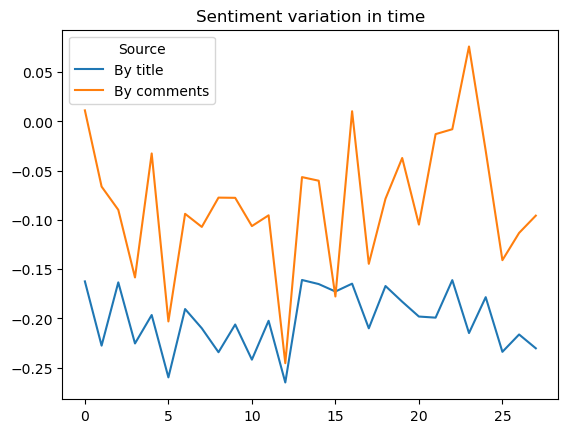

In [79]:
df =  dfFromCSV('_sentiment.csv')

months = df.groupby(['month']).size().sort_values(ascending=False).reset_index(name='count')
sentiment = df.groupby(['month']).sum()
#print(sentiment[['sentiment_t', 'sentiment_c']])
#count_period = words.groupby(['period']).size().sort_values(ascending=False).reset_index(name='count')

months = months.sort_values(by='month').reset_index()
months['sentiment_t'] = sentiment['sentiment_t'] / months['count']
months['sentiment_c'] = sentiment['sentiment_c'] / months['count']

plt.plot(months[['sentiment_t', 'sentiment_c']])
plt.legend(['By title', 'By comments'], loc='best', title='Source')
plt.title('Sentiment variation in time')
months

In [348]:
import nltk

df = dfFromCSV("_sorted.csv")

df['word'] = df['title'].str.split(' ')
df = df.explode('word')
df['word'] = df['word'].apply(str.strip)
df = df[(df['word'] != '') & (df['word'] is not None)]


temp = df['word'].apply(str)

treebankTagger = nltk.data.load('taggers/maxent_treebank_pos_tagger/english.pickle')
pos_tags = treebankTagger.tag[temp]

#pos_tags = nltk.tag.pos_tag(temp)
pos_tags = [b for a,b in pos_tags]
df['pos_tag'] = pd.Series(pos_tags)

dfToCSV(df, '_pos.csv')

df

LookupError: 
**********************************************************************
  Resource [93mmaxent_treebank_pos_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('maxent_treebank_pos_tagger')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/maxent_treebank_pos_tagger/PY3/english.pickle[0m

  Searched in:
    - '/home/ruru22/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


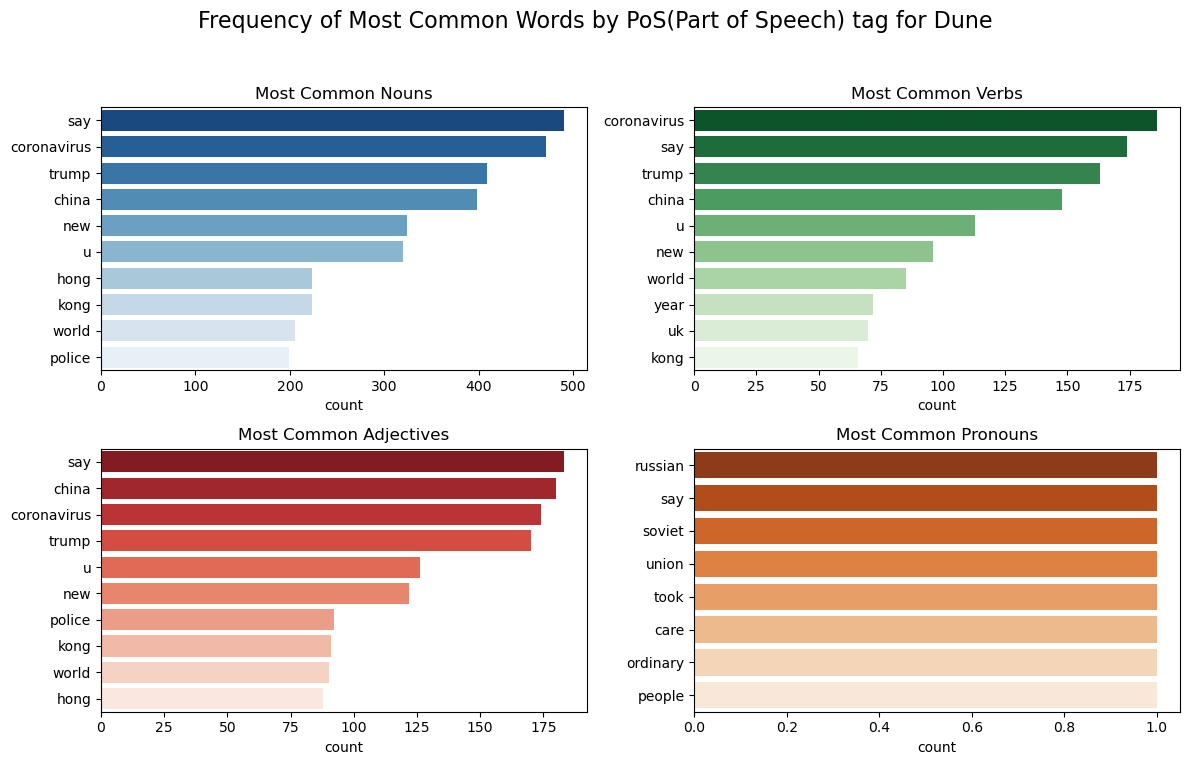

In [347]:
noun_counts = df.loc[df['pos_tag'].str.startswith('N'), 'word'].value_counts().head(10) 
verb_counts = df.loc[df['pos_tag'].str.startswith('V'), 'word'].value_counts().head(10)
adj_counts = df.loc[df['pos_tag'].str.startswith('JJ'), 'word'].value_counts().head(10)
pronoun_counts = df.loc[df['pos_tag'].str.startswith('PR'), 'word'].value_counts().head(10)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.barplot(x=noun_counts, y=noun_counts.index, ax=axes[0, 0], palette='Blues_r') 
sns.barplot(x=verb_counts, y=verb_counts.index, ax=axes[0, 1], palette='Greens_r') 
sns.barplot(x=adj_counts, y=adj_counts.index, ax=axes[1, 0], palette='Reds_r') 
sns.barplot(x=pronoun_counts, y=pronoun_counts.index, ax=axes[1, 1], palette='Oranges_r')

axes[0, 0].set_title('Most Common Nouns')
axes[0, 1].set_title('Most Common Verbs')
axes[1, 0].set_title('Most Common Adjectives')
axes[1, 1].set_title('Most Common Pronouns')


for ax in axes.flat:
    ax.set_ylabel('')

plt.suptitle('Frequency of Most Common Words by PoS', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
import pyLDAvis
import pyLDAvis.lda_model

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df = dfFromCSV('_sorted.csv')
df['text'] = df['text'].astype(str)

df

MONTHS = df['id'].unique()

texts = []
for month in MONTHS:
    texts.append(''.join(df['text'][df['id']==month]))
    #print(month)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_document_matrix = vectorizer.fit_transform(texts)

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(term_document_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words)

visualization_data = pyLDAvis.lda_model.prepare(lda, term_document_matrix, vectorizer)

pyLDAvis.display(visualization_data)

Topic #1: climate change year like people world time need make going
Topic #2: people virus like case time country death coronavirus day mask
Topic #3: israel drug brazil palestinian bolsonaro israeli feedback tl said make
Topic #4: china country chinese people war world like government iran hong
Topic #5: trump like russia president people russian know putin say time
Topic #6: tl feedback quot 039 original 23 version pm monitored summary
Topic #7: cunt uk eu like brexit people vote boris time year
Topic #8: article source contact moderator question help reader news animal user
Topic #9: people like right child woman police good time thing year
Topic #10: people money company like work pay tax make good need


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = dfFromCSV("_sorted.csv")
df['text'] = df['text'].astype(str)

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
temp = vectorizer.fit_transform(df['text'])
temp.toarray()

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(temp)

clusters = kmeans.labels_
print(len(clusters), clusters)

pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(temp.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1
df

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(temp.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)

df

/home/ruru22/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8691 [5 4 4 ... 2 9 2]

Cluster 0
quot,people,chinese,protester,police,protest,hk,china,kong,hong

Cluster 1
thing,police,fuck,country,one,get,would,right,like,people

Cluster 2
removed,good,country,get,one,would,china,people,deleted,like

Cluster 3
linking,sensationalized,verifies,help,question,source,article,contact,moderator,reader

Cluster 4
time,need,one,good,get,money,would,like,company,people

Cluster 5
iran,get,war,putin,like,would,russian,russia,president,trump

Cluster 6
covid,number,infected,get,like,china,coronavirus,case,people,virus

Cluster 7
planet,world,global,year,fuel,energy,emission,carbon,change,climate

Cluster 8
subscription,discouraged,paywalls,flaired,contact,user,submission,moderator,paywall,metered

Cluster 9
monitored,constructive,drs,keywords,autotldr,faq,039,quot,tl,feedback


,index,id,time,title,author,score,num_comments,text,month,cluster,x0,x1
0,0,ab2pn3,0.0,macron former aide admits using diplomatic pas...,NaN,301,5,pretty huge story france let give detail case ...,-0.0,5,-0.016464,0.048749
1,0,ab33i1,2801.0,bacteria found ancient irish soil halt growth ...,bhel_,5058,62,something muck dirt buddy mine gross wart hand...,-0.0,4,-0.024470,0.058175
2,0,ab36ix,3411.0,korea ban use disposable shopping bag supermarket,edwinksl,8930,81,cafe illegal serve drink paper plastic cup dri...,-0.0,4,-0.029138,0.104364
3,0,ab3esx,5137.0,footage show saudi hit team carrying bag belie...,AWACS-Thunderhead,2022,24,anyone know turkey managed get audio recording...,-0.0,5,-0.021123,0.024439
4,0,ab3eyp,5167.0,trump worst perpetrator false information amer...,glasier,72507,35,remember said releasing jfk file still waiting...,-0.0,5,-0.004523,0.093700
...,...,...,...,...,...,...,...,...,...,...,...,...
8686,42,mndr89,71738407.0,pressure xinjiang china take aim overseas uigh...,edourdoo1,180,8,friday event official took aim database set ov...,27.0,9,-0.090510,-0.137294
8687,53,mne5su,71740259.0,norwegian prime minister fined police breaking...,NaN,2634,26,deleted first thought norwegian good able dodg...,27.0,9,-0.045834,-0.046228
8688,51,mne6ah,71740331.0,south korea launch first homegrown supersonic ...,brownandbumpy,178,9,final test completed future south korea become...,27.0,2,-0.040478,-0.023358
8689,63,mnekkn,71742080.0,bike lane canada commits 400 m build sustaina...,ellalingling,106,9,putting infrastructure get 8 month long summ...,27.0,9,-0.071039,-0.068274


/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


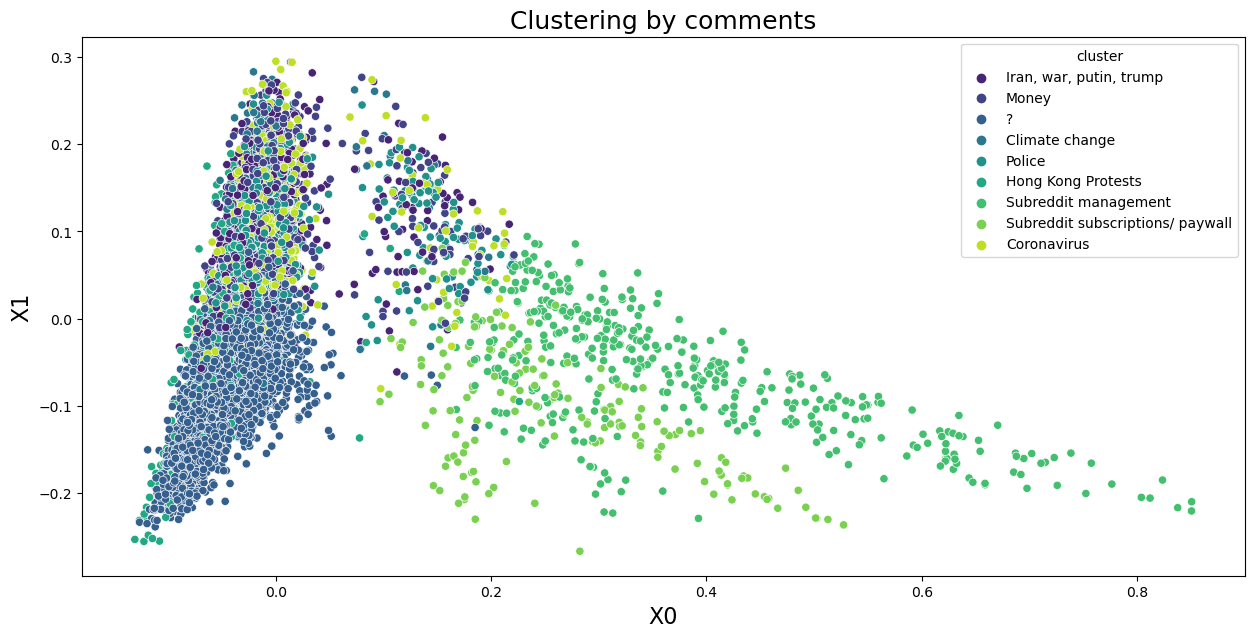

In [69]:
# map clusters to appropriate labels 
cluster_map = {
    0: "Hong Kong Protests", 
    1: "Police", 
    2: "?", 
    3: "Subreddit management", 
    4: "Money", 
    5: "Iran, war, putin, trump", 
    6: "Coronavirus", 
    7: "Climate change", 
    8: "Subreddit subscriptions/ paywall", 
    9: "?"
}

# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)
# set image size
plt.figure(figsize=(15, 7))
# set a title
plt.title("Clustering by comments", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

/home/ruru22/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8691 [1 1 1 ... 1 1 1]

Cluster 0
new,eu,say,coronavirus,uk,brexit,boris,johnson,million,people

Cluster 1
first,police,climate,chinese,case,uk,year,new,say,coronavirus

Cluster 2
president,brazilian,news,say,fire,coronavirus,bolsonaro,amazon,brazil,world

Cluster 3
iran,impeachment,official,ukraine,russia,administration,president,say,donald,trump

Cluster 4
everywhere,evidence,excess,exchange,exclusion,exec,executed,ever,user,deleted

Cluster 5
student,activist,chinese,law,china,protester,police,protest,hong,kong

Cluster 6
india,new,report,beijing,virus,uighur,say,taiwan,coronavirus,china


/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruru22/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


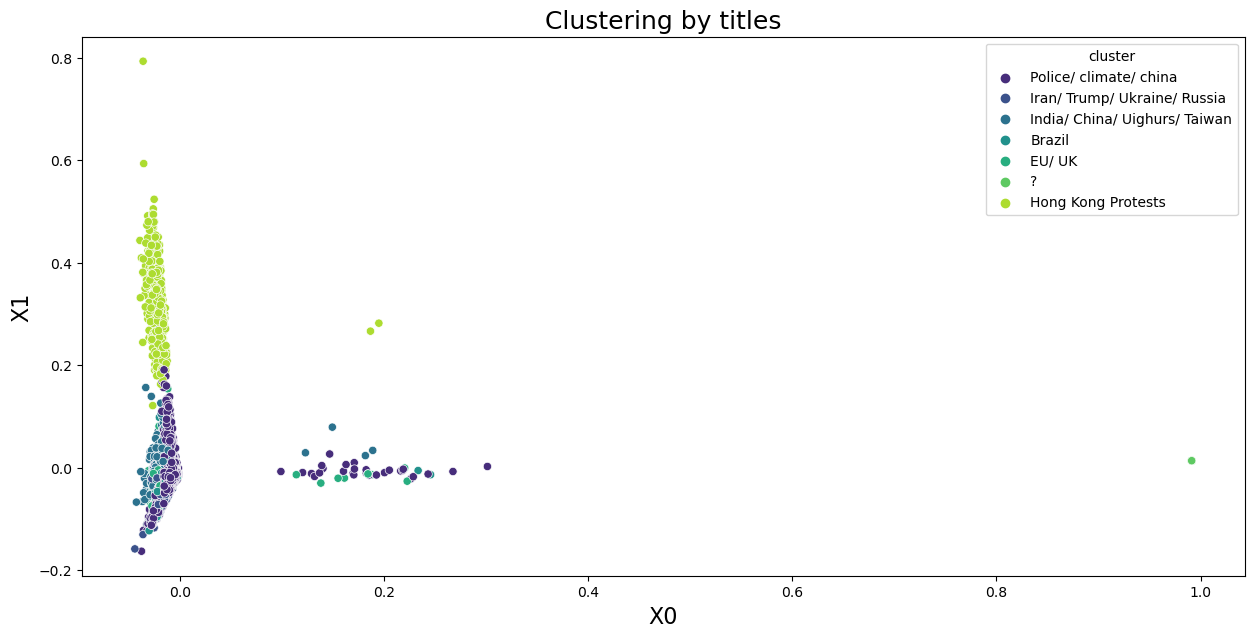

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = dfFromCSV("_sorted.csv")
df['title'] = df['title'].astype(str)

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
temp = vectorizer.fit_transform(df['title'])
temp.toarray()

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(temp)

clusters = kmeans.labels_
print(len(clusters), clusters)

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(temp.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1
df

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(temp.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)

# map clusters to appropriate labels 
cluster_map = {
    0: "EU/ UK", 
    1: "Police/ climate/ china", 
    2: "Brazil", 
    3: "Iran/ Trump/ Ukraine/ Russia", 
    4: "?", 
    5: "Hong Kong Protests", 
    6: "India/ China/ Uighurs/ Taiwan"
}

# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)
# set image size
plt.figure(figsize=(15, 7))
# set a title
plt.title("Clustering by titles", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#plt.xlim(-0.05,0)
#plt.ylim(-0.02,0.02)
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()